In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import gurobipy as gp
from gurobipy import GRB
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyArrowPatch

In [14]:
names = locals()

In [2]:
def emissions_storage_matching(df_capacity, df_demand, distances_matrix): 
    # Convert inputs to NumPy arrays for fast matrix operations
    capacities_ = df_capacity.values
    capacities = capacities_[capacities_ > 0] 
    producers = np.where(capacities_ > 0)[0].tolist()

    demands_ = df_demand.values
    demands = demands_[demands_ > 0]
    markets = np.where(demands_ > 0)[0].tolist()

    num_producers = len(producers)
    num_markets = len(markets)
    
    # Set the maximum distance for local supply in the first stage
    max_local_distance = 1000
    distances_matrix = distances_matrix[producers][:, markets] 
    local_mask = distances_matrix <= max_local_distance
    
    # ----------------------------- Stage 1a: Maximize Local Supply -----------------------------
    # Initialize the Gurobi model for Stage 1a
    model_stage1a = gp.Model("Cement_Plant_Distribution_Stage1_MaxSupply")
    
    # Decision variable matrix: shipment_stage1[i, j] is the shipment from plant i to market j
    shipment_stage1 = model_stage1a.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1")

    # Objective: Maximize local supply (only considering local distances)
    model_stage1a.setObjective((shipment_stage1 * local_mask).sum(), GRB.MAXIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1a.addConstr(shipment_stage1.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1a")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1a.addConstr((shipment_stage1 * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1a")

    # Optimize Stage 1a 
    model_stage1a.optimize()
    if model_stage1a.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1a")
    max_local_supply = shipment_stage1.X.sum()  # Total local supply

    # ----------------------------- Stage 1b: Minimize Distance with Max Local Supply -----------------------------
    # Initialize the Gurobi model for Stage 1b
    model_stage1b = gp.Model("Cement_Plant_Distribution_Stage1_MinDist")
    
    # Decision variable matrix: shipment_stage1 in Stage 1b (reused)
    shipment_stage1b = model_stage1b.addMVar((num_producers, num_markets), vtype=GRB.CONTINUOUS, name="shipment_stage1b")
    
    # Objective: Minimize the shipment distance for local supply
    model_stage1b.setObjective((shipment_stage1b * distances_matrix * local_mask).sum(), GRB.MINIMIZE)

    # Constraint 1: Plant capacity should not be exceeded
    model_stage1b.addConstr(shipment_stage1b.sum(axis=1) <= capacities, name="Capacity_Constraint_Stage1b")

    # Constraint 2: Market demands should be satisfied within local constraints
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum(axis=0) <= demands, name="Demand_Constraint_Stage1b")

    # Constraint 3: Ensure that the total shipment matches the maximum local supply found in Stage 1a
    model_stage1b.addConstr((shipment_stage1b * local_mask).sum() == max_local_supply, name="Max_Local_Supply_Constraint") 

    # Optimize Stage 1b
    model_stage1b.optimize()
    if model_stage1b.status == GRB.OPTIMAL:
        print("Successful optimization for Stage 1b")
    
    # Extract the shipment matrix from Stage 1
    shipment_matrix_stage1 = shipment_stage1b.X
    print(np.nansum(shipment_matrix_stage1))

    # Convert the result back to a DataFrame for easier handling
    shipment_matrix_final = shipment_matrix_stage1
    n = 2873
    hh = [i for i in range(n)]
    shipment_matrix_df = pd.DataFrame([], index=hh, columns=hh) 
    shipment_matrix_df.loc[producers, markets] = shipment_matrix_final

    return shipment_matrix_df

In [ ]:
county_production_POP = pd.read_csv('../outputs/China_county_production_POP.csv', index_col=3)
county_CO2_POP = pd.read_csv('../outputs/China_county_CO2_POP.csv', index_col=0)
county_CO2_GDP = pd.read_csv('../outputs/China_county_CO2_GDP.csv', index_col=0)
county_CO2_combined = pd.read_csv('../outputs/China_county_CO2_combined.csv', index_col=0)
county_storage_potential = pd.read_csv('../outputs/China_county_carbon_storage.csv', index_col=3)

In [10]:
storage_capacity = pd.Series(county_storage_potential[['G_DSA', 'G_EOR']].sum(axis=1)[county_production_POP.index].values.round(1).tolist())

In [ ]:
county_shortest_distances = pd.read_csv('../data/shortest_distances_matrix.csv', index_col=0)
county_shortest_distances = county_shortest_distances.drop([176, 638, 639, 2403])
county_shortest_distances = county_shortest_distances.drop(['176', '638', '639', '2403'], axis=1)
county_distance_matrix = county_shortest_distances.values

In [15]:
for t in [2030, 2040, 2050]:
    names[f'cum_CO2_{t}_POP'] = pd.Series((county_CO2_POP.loc[2021:t].sum() / 1e3).values.round(1).tolist()) 
    names[f'storage_matrix_{t}_POP'] = emissions_storage_matching(storage_capacity, names[f'cum_CO2_{t}_POP'], county_distance_matrix)

Set parameter Username
Set parameter LicenseID to value 2622808
Academic license - for non-commercial use only - expires 2026-02-17
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 2190 rows, 1120064 columns and 1349533 nonzeros
Model fingerprint: 0x2af08b29
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+03]
Presolve removed 88 rows and 891599 columns
Presolve time: 0.43s
Presolved: 2102 rows, 228465 columns, 456725 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.08s

Barrier performed 0 iterations in 0.56 seconds (0.72 work units)
Barrier solve interrupted - model solved by another alg

In [16]:
for t in [2030, 2040, 2050]:
    names[f'cum_CO2_{t}_GDP'] = pd.Series((county_CO2_GDP.loc[2021:t].sum() / 1e3).values.round(1).tolist()) 
    names[f'storage_matrix_{t}_GDP'] = emissions_storage_matching(storage_capacity, names[f'cum_CO2_{t}_GDP'], county_distance_matrix)

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 2190 rows, 1120064 columns and 1349533 nonzeros
Model fingerprint: 0x8b04bd5d
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+03]
Presolve removed 105 rows and 891820 columns
Presolve time: 0.32s
Presolved: 2085 rows, 228244 columns, 456272 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.08s

Barrier performed 0 iterations in 0.44 seconds (0.70 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1449    9.6503000e+03   0.0

In [17]:
for t in [2030, 2040, 2050]:
    names[f'cum_CO2_{t}_combined'] = pd.Series((county_CO2_combined.loc[2021:t].sum() / 1e3).values.round(1).tolist()) 
    names[f'storage_matrix_{t}_combined'] = emissions_storage_matching(storage_capacity, names[f'cum_CO2_{t}_combined'], county_distance_matrix)

Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 9 7950X 16-Core Processor, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 16 physical cores, 32 logical processors, using up to 32 threads

Optimize a model with 2190 rows, 1120064 columns and 1349533 nonzeros
Model fingerprint: 0x61bf5cda
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-01, 3e+03]
Presolve removed 94 rows and 891705 columns
Presolve time: 0.36s
Presolved: 2096 rows, 228359 columns, 456513 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.09s

Barrier performed 0 iterations in 0.51 seconds (0.71 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with primal simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
    1407    9.6493000e+03   0.00

C:\Users\Administrator\AppData\Local\Temp\ipykernel_60692\2995223651.py:2: RuntimeWarning: invalid value encountered in greater
  plt.hist(county_distance_matrix[storage_matrix_2030_POP.values > 0], bins=bin_edges, alpha=0.5, label='2030')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_60692\2995223651.py:3: RuntimeWarning: invalid value encountered in greater
  plt.hist(county_distance_matrix[storage_matrix_2040_POP.values > 0], bins=bin_edges, alpha=0.5, label='2040')
C:\Users\Administrator\AppData\Local\Temp\ipykernel_60692\2995223651.py:4: RuntimeWarning: invalid value encountered in greater
  plt.hist(county_distance_matrix[storage_matrix_2050_POP.values > 0], bins=bin_edges, alpha=0.5, label='2050')


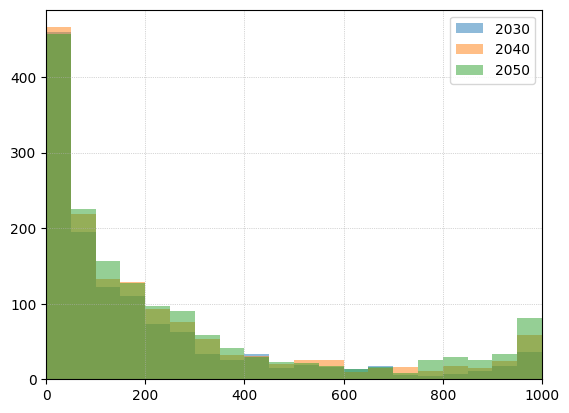

In [18]:
bin_edges = np.linspace(0, 1e3, num=21)
plt.hist(county_distance_matrix[storage_matrix_2030_POP.values > 0], bins=bin_edges, alpha=0.5, label='2030')
plt.hist(county_distance_matrix[storage_matrix_2040_POP.values > 0], bins=bin_edges, alpha=0.5, label='2040')
plt.hist(county_distance_matrix[storage_matrix_2050_POP.values > 0], bins=bin_edges, alpha=0.5, label='2050')
plt.xlim([0, 1e3])
plt.legend(loc='best')
plt.grid('on', ls=':', lw=0.5)

plt.show()

In [19]:
def compile_matching_results(storage_matrix):
    aa = np.where(storage_matrix.values.astype(float) > 0, county_distance_matrix, 0)
    bb = np.where(storage_matrix.values.astype(float) > 0, storage_matrix.values, 0)
    cc = (aa * bb).astype(float)
    dd = cc.sum(axis=0)
    ee = bb.sum(axis=0)
    ff = dd / np.where(ee == 0, np.nan, ee) 
    gg = bb.sum(axis=0).astype(float)

    y = gg
    x = ff

    return x, y 

In [23]:
weighted_distance_2050_POP, stored_CO2_2050_POP = compile_matching_results(storage_matrix_2050_POP)
weighted_distance_2050_GDP, stored_CO2_2050_GDP = compile_matching_results(storage_matrix_2050_GDP)
weighted_distance_2050_combined, stored_CO2_2050_combined = compile_matching_results(storage_matrix_2050_combined)

In [24]:
DF_results = pd.DataFrame([])
DF_results['cum_CO2_2050_POP'] = cum_CO2_2050_POP
DF_results['cum_CO2_2050_GDP'] = cum_CO2_2050_GDP
DF_results['cum_CO2_2050_combined'] = cum_CO2_2050_combined

In [25]:
DF_results['weighted_distance_2050_POP'] = weighted_distance_2050_POP
DF_results['weighted_distance_2050_GDP'] = weighted_distance_2050_GDP
DF_results['weighted_distance_2050_combined'] = weighted_distance_2050_combined

In [26]:
DF_results['stored_CO2_2050_POP'] = stored_CO2_2050_POP
DF_results['stored_CO2_2050_GDP'] = stored_CO2_2050_GDP
DF_results['stored_CO2_2050_combined'] = stored_CO2_2050_combined

In [28]:
DF_results.to_csv('../outputs/matched_emissions_storage.csv', )

In [36]:
storage_matrix_2030_POP.to_csv('../outputs/storage_matrix_2030_POP.csv')
storage_matrix_2030_GDP.to_csv('../outputs/storage_matrix_2030_GDP.csv')
storage_matrix_2030_combined.to_csv('../outputs/storage_matrix_2030_combined.csv')

In [35]:
storage_matrix_2040_POP.to_csv('../outputs/storage_matrix_2040_POP.csv')
storage_matrix_2040_GDP.to_csv('../outputs/storage_matrix_2040_GDP.csv')
storage_matrix_2040_combined.to_csv('../outputs/storage_matrix_2040_combined.csv')

In [ ]:
storage_matrix_2050_POP.to_csv('../outputs/storage_matrix_2050_POP.csv')
storage_matrix_2050_GDP.to_csv('../outputs/storage_matrix_2050_GDP.csv')
storage_matrix_2050_combined.to_csv('../outputs/storage_matrix_2050_combined.csv')